In [1]:
from clustering import Clustering,Trajectory
from utils import refactor_and_plot,display_clusters_oat
import time

import sklearn
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import cv2
from color import colors

from numpy.linalg import inv

from scipy.spatial.distance import euclidean,cityblock,squareform
from scipy.cluster.hierarchy import dendrogram, linkage, ward, fcluster,cophenet

from fastdtw import fastdtw

from sklearn.cluster import DBSCAN, AgglomerativeClustering, AffinityPropagation, SpectralClustering
import scipy.spatial.distance as ssd

ImportError: No module named utils

In [2]:
c = Clustering("laurier/laurier.sqlite","laurier/laurier-homography.txt")
c.get_trajectories(pixels = 1)
c.discretize_pixel_trajectories(square_side_size = 50)

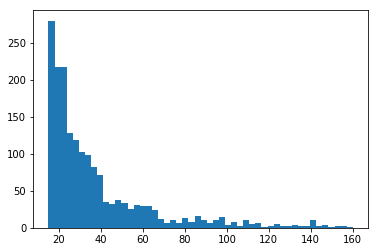

In [4]:
c.plot_pixel_trajectory_lengths_distribution(nb_bins = 50, mask = 0)

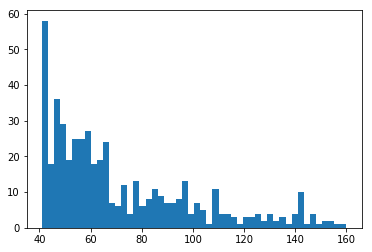

In [15]:
c.threshold_pixels_trajectory_length(threshold = 40 )
c.plot_pixel_trajectory_lengths_distribution(nb_bins = 50, mask = 1)

In [5]:
start = time.time()
c.compute_dtw_distance_matrix(mask = 1)
print(time.time()-start)

1792


KeyboardInterrupt: 

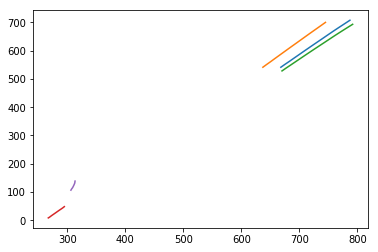

In [23]:
pixel_traj = [trajectory.pixel_trajectory for trajectory in c.trajectories]

refactor_and_plot(pixel_traj)

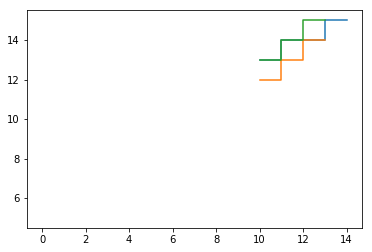

In [28]:
discret_traj = [trajectory.discretized_trajectory for trajectory in c.trajectories]
refactor_and_plot(discret_traj[:5])

In [3]:
c.load_dtw_distance_matrix("Distances/cityblock_50.txt")

# Clustering

## Hierarchical clustering

In [4]:
Z = linkage(squareform(c.distance_matrix), 'ward')

### Cophenet distance:  
The closer the value is to 1, 
the better the clustering preserves the original distances, which in our case is pretty close

In [8]:
ct, coph_dists = cophenet(Z, squareform(c.distance_matrix))
print(ct)

0.5691295532661443


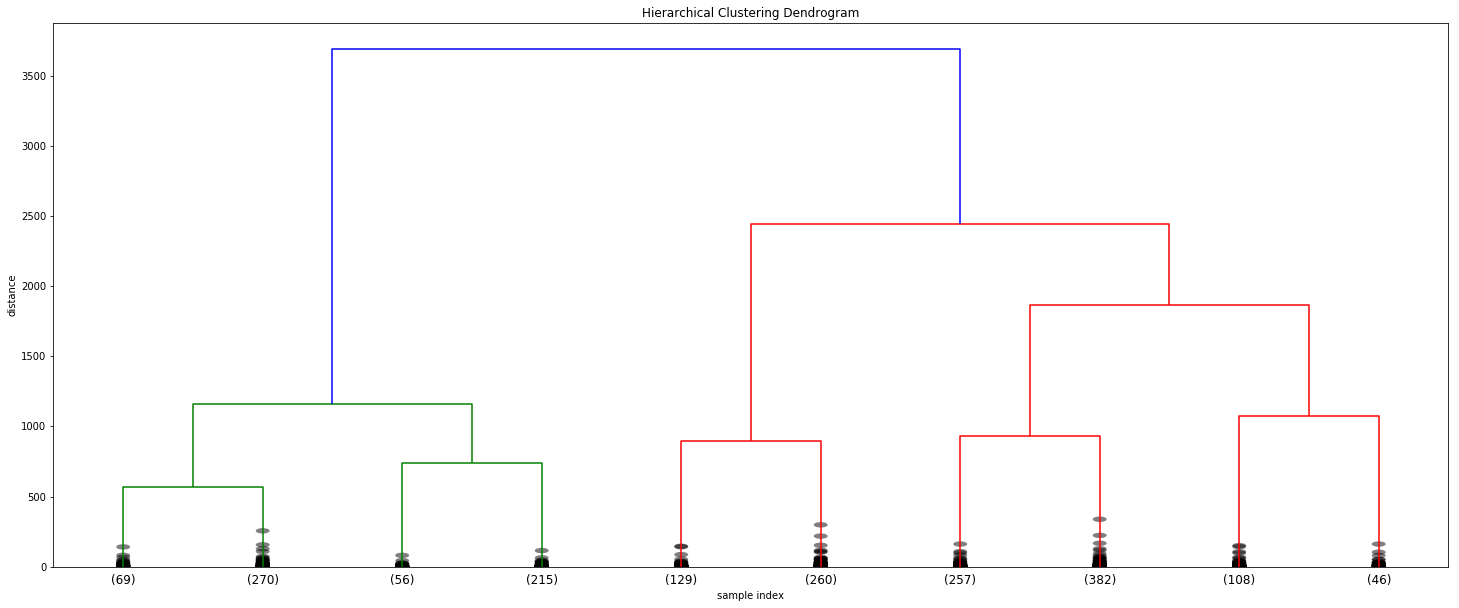

In [5]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=10,  # show only the last p merged clusters
    show_leaf_counts=True,
    show_contracted=True
)
plt.show()

In [20]:
max_distance = 50
clusters = fcluster(Z,max_distance, criterion='distance')
print(clusters[:20])

[ 9 12 35 35 12 12 11 11 11 35 35 25 25 25 25 25 25 25 24 25]


In [6]:
nb_clusters = 6
clusters = fcluster(Z, nb_clusters, criterion='maxclust')

In [7]:
def display_clusters_aao(clusters,filename,pixel_trajectories,colors):
    nb_clusters = np.max(clusters)+1
    cap = cv2.VideoCapture(filename)
    ret, frame = cap.read()
    for i in range(1,nb_clusters+1):
        for j,c in enumerate(clusters):
            if c == i:
                pts = np.array(pixel_trajectories[j] , np.int32)
                pts = pts.reshape((-1,1,2))
                color = colors[clusters[j]-1] *255
                frame = cv2.polylines(frame,[pts],False,tuple(color[:-1]) )
    cv2.imshow('frame',frame)
    if cv2.waitKey(0) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
    #cap.release()
    #cv2.destroyAllWindows()


In [13]:
import matplotlib.cm as cm
import cv2
colors = cm.rainbow(np.linspace(0, 1, nb_clusters))
filename = "laurier/laurier.avi"
trajectories = [trajectory.pixel_trajectory for trajectory in c.trajectories]
display_clusters_aao(clusters,filename,trajectories,colors)

In [14]:
display_clusters_oat(clusters,"laurier/laurier.avi",[trajectory.pixel_trajectory for trajectory in c.trajectories])

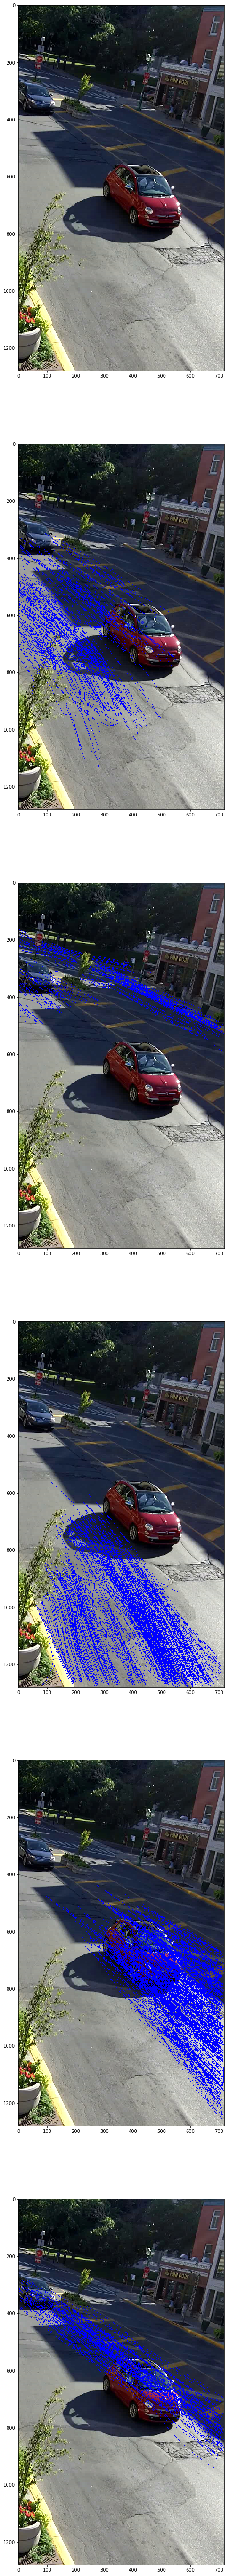

In [12]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import copy
import cv2

img = mpimg.imread("laurier/laurier.jpg")
fig = plt.figure(figsize=(10,100))

columns = 1
rows = nb_clusters

for i in range(nb_clusters):
    fig.add_subplot(rows,columns,i+1)
    img1 = copy.copy(img)
    for j,cl in enumerate(clusters):
        if cl == i:
            #img = mpimg.imread("laurier/laurier.jpg")
            
            pts = np.array(c.trajectories[j].pixel_trajectory , np.int32)
            pts = pts.reshape((-1,1,2))
            img1 = cv2.polylines(img1,[pts],False,(0,0,255)) 
    plt.imshow(img1)

plt.show()